c:\users\evan\documents\github\simulatedoptimization\venv\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\users\evan\documents\github\simulatedoptimization\venv\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.5936]), std = tensor([0.3319])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


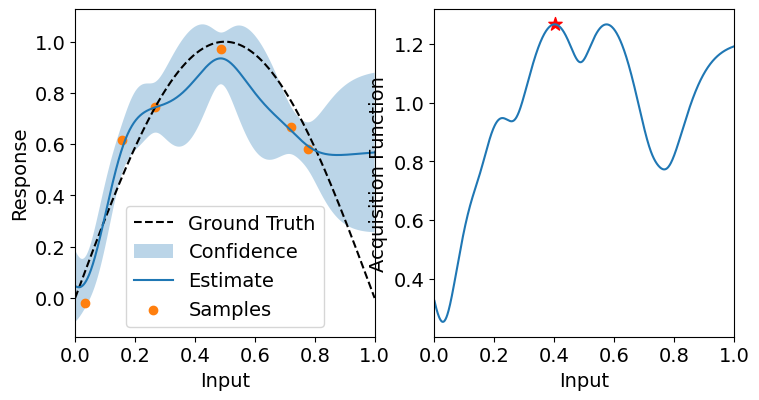

In [47]:
from botorch import fit_gpytorch_mll
from gpytorch import ExactMarginalLogLikelihood
import numpy as np
from matplotlib import pyplot as plt
from botorch.models import SingleTaskGP
from gpytorch.kernels import MaternKernel
import gpytorch

import torch

plt.rcParams['svg.fonttype'] = 'none'

torch.random.manual_seed(623)
xs = torch.rand((6))
test_data = torch.sin(torch.pi*xs)
test_data += 0.15 * torch.randn(test_data.shape)

covar_module = gpytorch.kernels.ScaleKernel(MaternKernel())
covar_module.outputscale = 1
model = SingleTaskGP(xs.unsqueeze(-1), test_data.unsqueeze(-1), covar_module=covar_module)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

interp = np.linspace(0, 1, 1000)
post = model.posterior(torch.linspace(0, 1, 1000), observation_noise=False)
var = post.variance.detach().cpu().numpy()
mean = post.mean.detach().cpu().numpy()

fig = plt.figure(figsize=(8.5, 4.25))
plt.rcParams.update({'font.size': 14})
fig.add_subplot(121)
plt.plot(interp, np.sin(np.pi*interp), linestyle='--', color='black')
plt.fill_between(interp, np.squeeze(mean - np.sqrt(var)), np.squeeze(mean + np.sqrt(var)), alpha=0.3)
plt.plot(interp, mean)
plt.scatter(xs, test_data)
plt.xlim(0, 1)
plt.xlabel('Input')
plt.ylabel('Response')
plt.legend(['Ground Truth', 'Confidence', 'Estimate', 'Samples'])
fig.add_subplot(122)
plt.plot(interp, mean + 2 * np.sqrt(var))
maxI = np.argmax(mean + 2 * np.sqrt(var))
plt.scatter(interp[maxI], mean[maxI] + 2 * np.sqrt(var[maxI]), 100, marker='*', color='red')
plt.xlim(0, 1)
plt.xlabel('Input')
plt.ylabel('Acquisition Function')
plt.savefig('figures/figure1_gp-acqf.svg')